In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'E:\Projects\walmart_analytics\Cleaned Data\cleaned_data.csv')
df.dtypes

invoice_id          int64
branch             object
city               object
category           object
unit_price        float64
quantity          float64
date               object
payment_method     object
rating            float64
profit_margin     float64
total_price       float64
hour                int64
dtype: object

In [4]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Coerce errors to NaT if there are any invalid dates
df = df.dropna(subset=['date'])  # Drop rows where 'date' is NaT after conversion
df.set_index('date', inplace=True)

**Resample Data to Monthly Frequency**


In [16]:
# Resample the data to monthly frequency (summing total_price for each month)
monthly_data = df['total_price'].resample('ME').sum()

if monthly_data.isnull().sum() > 0:
    print("There are missing values in the resampled data. Filling with forward fill method.")
    monthly_data.fillna(method='ffill', inplace=True)


In [17]:
print(monthly_data.shape)


(60,)


In [18]:
print(monthly_data.index.min())  # First month
print(monthly_data.index.max())  # Last month


2019-01-31 00:00:00
2023-12-31 00:00:00


In [19]:
#stationarity using Augmented Dickey-Fuller test
result = adfuller(monthly_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.278206864727574
p-value: 0.015881180409772735


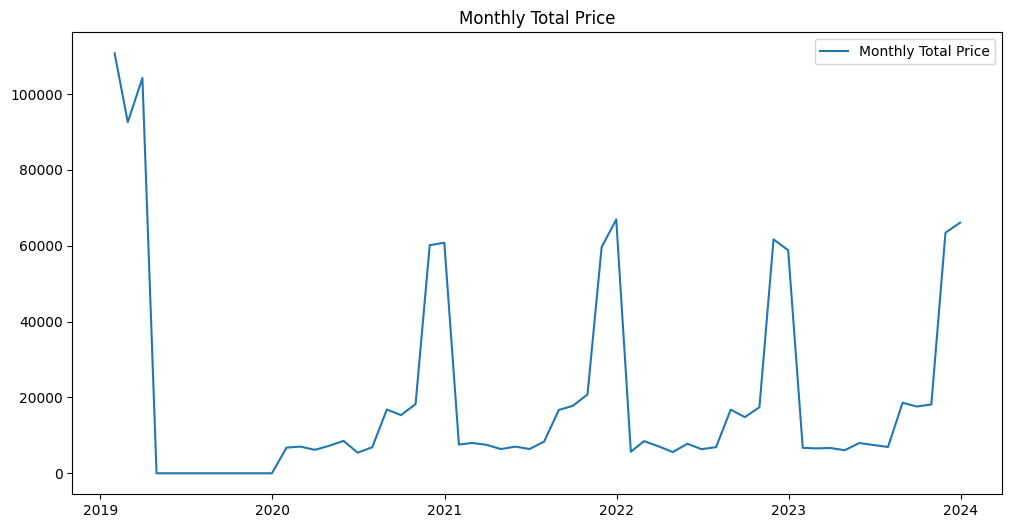

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Monthly Total Price')
plt.title('Monthly Total Price')
plt.legend()
plt.show()

 Custom Diagnostics Function



In [23]:
def custom_diagnostics(residuals):
    """Custom diagnostics for small sample sizes"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0,0].plot(residuals)
    axes[0,0].set_title('Residuals over Time')
    axes[0,0].axhline(y=0, color='r', linestyle='--')

    sns.histplot(residuals, kde=True, ax=axes[0,1])
    axes[0,1].set_title('Residuals Distribution')

    acf_values = acf(residuals, nlags=min(20, len(residuals)//2))
    axes[1,0].plot(range(len(acf_values)), acf_values)
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
    axes[1,0].axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
    axes[1,0].set_title('ACF of Residuals')

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # Statistical tests
    print("\nDiagnostic Tests:")
    # Shapiro-Wilk test for normality
    _, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test p-value: {p_value:.4f}")

    # Ljung-Box test using statsmodels
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(f"Ljung-Box test p-value: {lb_test['lb_pvalue'].values[0]:.4f}")
   
    print(f"\nResiduals Statistics:")
    print(f"Mean of residuals: {np.mean(residuals):.4f}")
    print(f"Std of residuals: {np.std(residuals):.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")



**Modelling**

In [24]:
def train_and_evaluate_sarima(data, test_size=0.2):
    # Split data
    train_size = int(len(data) * (1 - test_size))
    train = data[:train_size]
    test = data[train_size:]

    # Seasonal decomposition
    decomposition = seasonal_decompose(data, period=12)

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Original')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()

    # stationarity
    result = adfuller(data)
    print('Stationarity Test:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    #  model parameters
    order = (2, 1, 1)  # (p, d, q)
    seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

    # Fit model
    model = SARIMAX(train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    results = model.fit(disp=False)

    predictions = results.get_forecast(steps=len(test))
    pred_mean = predictions.predicted_mean
    pred_ci = predictions.conf_int()

    mae = mean_absolute_error(test, pred_mean)
    rmse = np.sqrt(mean_squared_error(test, pred_mean))
    mape = np.mean(np.abs((test - pred_mean) / test)) * 100

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data')
    plt.plot(test.index, pred_mean, label='Predictions', color='red')
    plt.fill_between(test.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1],
                    color='red', alpha=0.1)
    plt.title('SARIMA Time Series Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nModel Parameters:")
    print(f"SARIMA{order}x{seasonal_order}")
    print(f"\nModel Performance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Custom diagnostics
    residuals = results.resid
    custom_diagnostics(residuals)

    return results, pred_mean, (mae, rmse, mape)


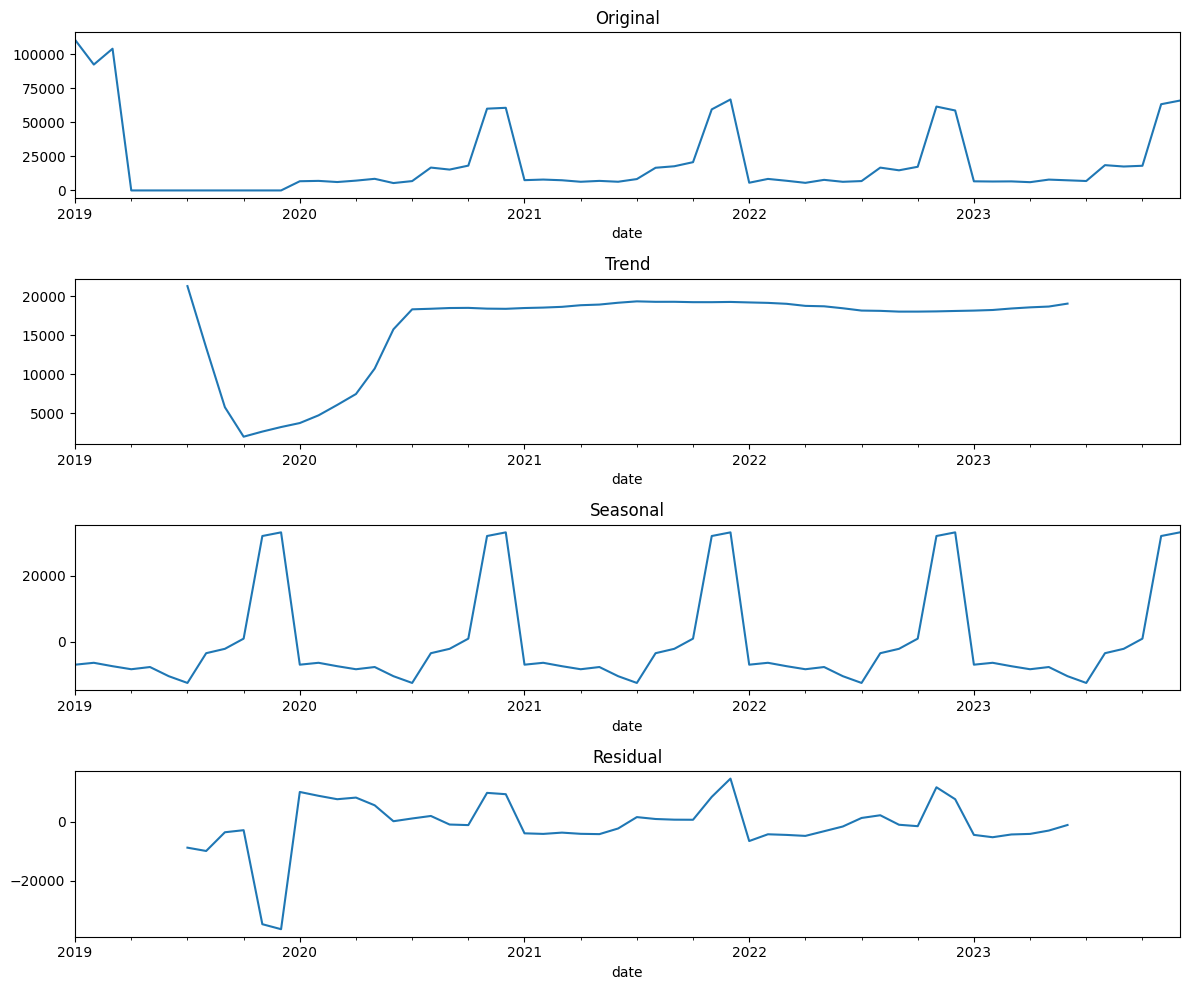

Stationarity Test:
ADF Statistic: -3.278206864727574
p-value: 0.015881180409772735
Critical values:
	1%: -3.552928203580539
	5%: -2.9147306250000002
	10%: -2.595137155612245


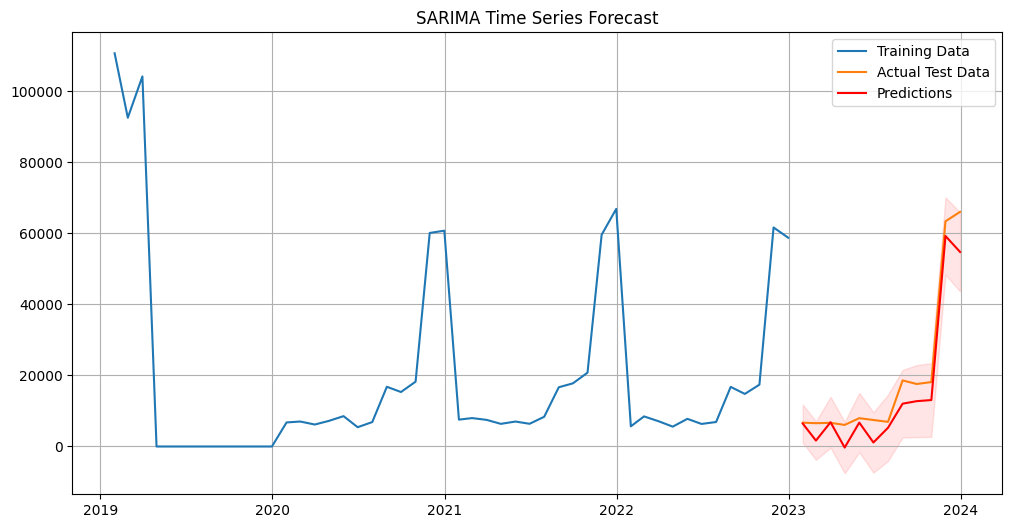


Model Parameters:
SARIMA(2, 1, 1)x(0, 1, 1, 12)

Model Performance Metrics:
MAE: 4402.12
RMSE: 5368.30
MAPE: 35.38%


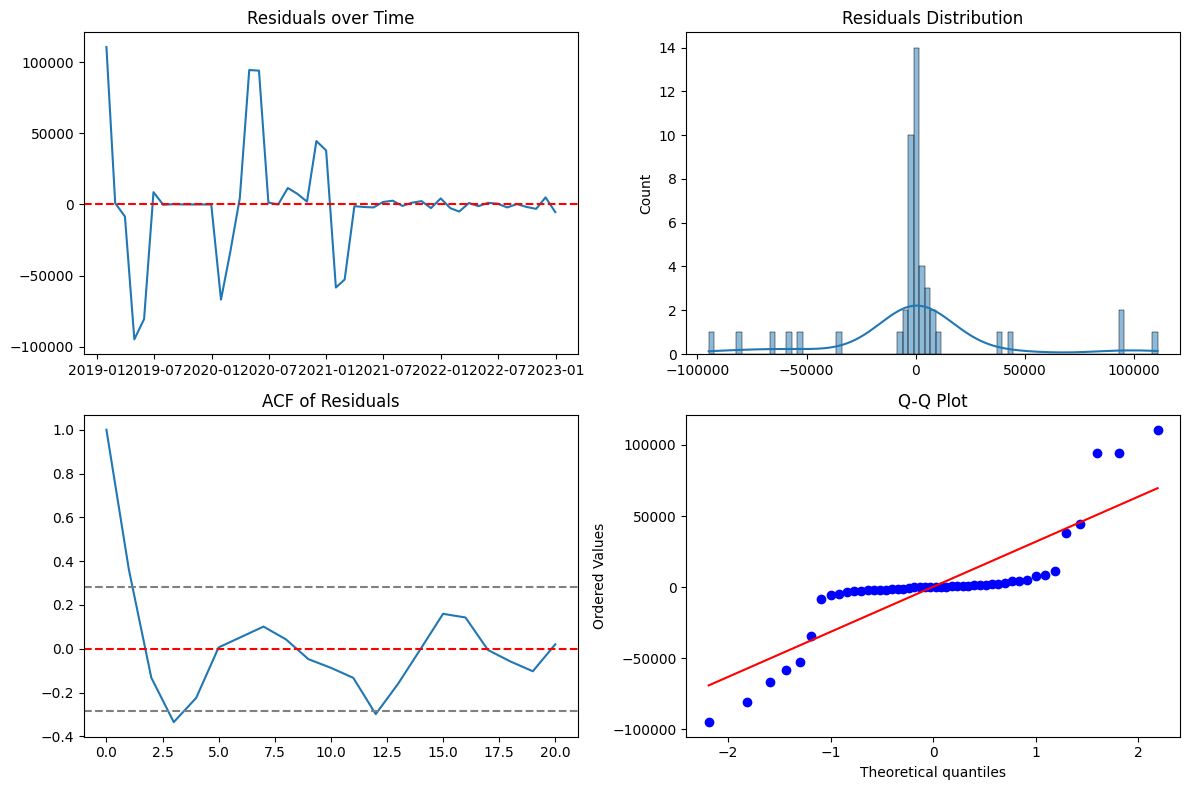


Diagnostic Tests:
Shapiro-Wilk test p-value: 0.0000
Ljung-Box test p-value: 0.0586

Residuals Statistics:
Mean of residuals: 272.1903
Std of residuals: 35744.7530
Skewness: 0.4880
Kurtosis: 3.0935


In [25]:

results, predictions, metrics = train_and_evaluate_sarima(monthly_data)


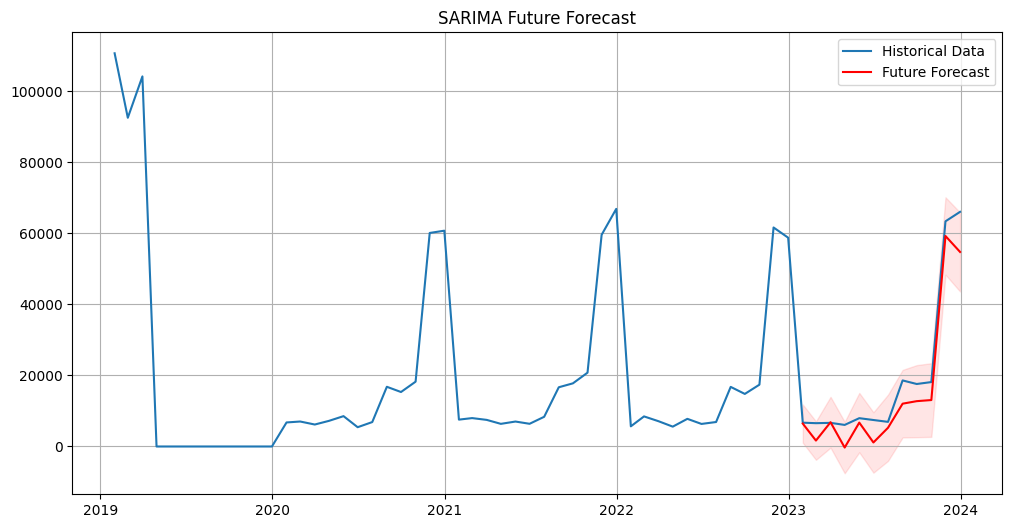


Forecast for next 12 months:
2023-01: 6454.37 [1072.19, 11836.56]
2023-02: 1665.26 [-3750.97, 7081.49]
2023-03: 6835.35 [-317.45, 13988.14]
2023-04: -298.24 [-7543.43, 6946.94]
2023-05: 6729.88 [-1633.84, 15093.61]
2023-06: 1130.99 [-7378.96, 9640.93]
2023-07: 5274.57 [-4051.89, 14601.03]
2023-08: 12060.20 [2545.79, 21574.61]
2023-09: 12769.91 [2615.49, 22924.32]
2023-10: 13082.25 [2710.37, 23454.14]
2023-11: 59292.25 [48393.09, 70191.42]
2023-12: 54790.41 [43654.47, 65926.35]


In [26]:
# future forecasts
future_steps = 12
future_forecast = results.get_forecast(steps=future_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data, label='Historical Data')
plt.plot(future_mean.index, future_mean, label='Future Forecast', color='red')
plt.fill_between(future_mean.index,
                future_ci.iloc[:, 0],
                future_ci.iloc[:, 1],
                color='red', alpha=0.1)
plt.title('SARIMA Future Forecast')
plt.legend()
plt.grid(True)
plt.show()

print("\nForecast for next 12 months:")
for date, value, ci_lower, ci_upper in zip(future_mean.index,
                                          future_mean.values,
                                          future_ci.iloc[:, 0],
                                          future_ci.iloc[:, 1]):
    print(f"{date.strftime('%Y-%m')}: {value:.2f} [{ci_lower:.2f}, {ci_upper:.2f}]")


**Rolling Average**

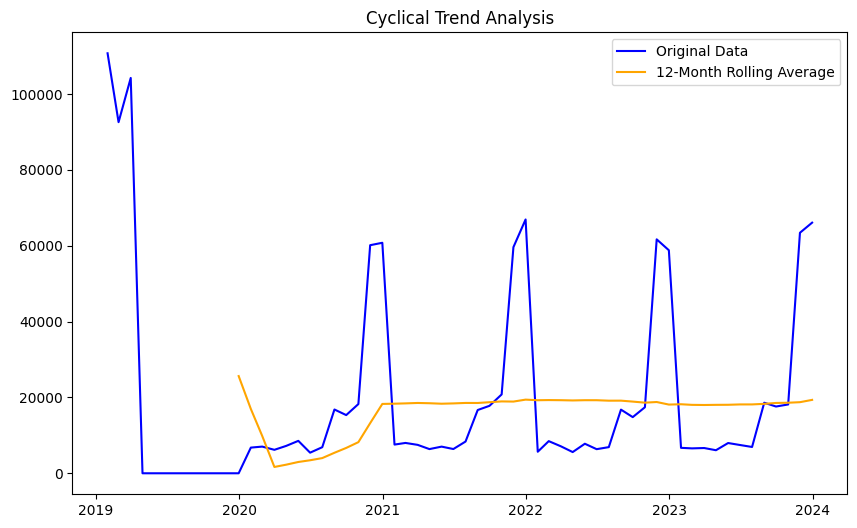

In [14]:
# Cyclical Analysis using 12-month rolling average
rolling_avg = monthly_data.rolling(window=12).mean()  # 12-month rolling average

plt.figure(figsize=(10, 6))
plt.plot(monthly_data, label='Original Data', color='blue')
plt.plot(rolling_avg, label='12-Month Rolling Average', color='orange')
plt.title('Cyclical Trend Analysis')
plt.legend()
plt.show()



In [15]:
import joblib

# Save the model
joblib.dump(results, 'sarima_model.pkl')


['sarima_model.pkl']